In [1]:
# !pip install mmh3
# !pip install pytorch-ignite
# !pip install -U tensorly-torch
# !pip install -U tensorly
# !pip install -U matplotlib

In [2]:
import pickle
import matplotlib.pyplot as plt

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# !head -n 12801 train_150_integer_from_dream2022_train_expression.txt > train_12801.txt

In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec  4 14:15:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1080      WDDM  |   00000000:01:00.0  On |                  N/A |
| 44%   57C    P8             14W /  180W |    1080MiB /   8192MiB |     12%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 68.7 gigabytes of available RAM

You are using a high-RAM runtime!


In [6]:
import os

GOOGLE_DRIVE_PATH_POST_MYDRIVE = "Colab_Notebooks/DL_group_proj"
GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['model']


In [7]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

In [8]:
# !pip install mmh3
# !pip install pytorch-ignite
# !pip install -U tensorly-torch
# !pip install -U tensorly

In [9]:
# !pip install -r {GOOGLE_DRIVE_PATH + "/requirements.txt"}
# import torch
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(DEVICE)

In [10]:
from helper_fuctions import *
from legnet import Bilinear, SELayer, SeqNN

c:\Users\rolfh\anaconda3\envs\nlpa3\Lib\site-packages\ignite\handlers\checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

cuda


In [12]:
model_dir = GOOGLE_DRIVE_PATH + '/model' # folder that will contatin all outputs {type:"string"}

# Architecture

In [13]:
'''
final_ch: number of channels of the final convolutional layer.

For challenge task it corresponds to the number of expression bins.
'''
final_ch = 18 # {type:"integer"}

'''
Number of channels for EffNet-like blocks
'''
blocks = [256, 128, 128, 64, 64, 64, 64] # {type:"list"}

'''
Kernel size of convolutional layers
'''
ks = 7 # {type:"integer"}

'''
Number of channels in a middle/high-dimensional convolutional layer of an EffNet-like block
'''
resize_factor = 4 # {type:"integer"}

'''
Reduction number used in SELayer
'''
se_reduction = 4 # {type:"integer"}

'''
BatchNorm momentum
'''
bn_momentum = .1 # {type:"float"}

# Training

In [14]:
seqsize = 150

loss = 'kl' # ["mse", "kl"] {type:"string"}

epoch_num = 100 # {type:"integer"}

batch_per_epoch = 20 # {type:"integer"}

optimizer_name = "adamw" # ["adam", "adamw", "rmsprop"] {type:"string"}

weight_decay = 0.01 # {type:"float"}

'''
Note: lr will be set manually via range test run for few epochs to find out good learning rate.
Warning: running range test will require you to manually set lr based on a training plot.
'''

train_batch_size = 256 # {type:"integer"}
valid_batch_size = 256 # {type:"integer"}

train_workers = 0 # {type:"integer"}
valid_workers = 0 # {type:"integer"}

'''
Additional binary channel with singleton information.
Integer expression values are considered as singletons measured in the GPRA experiment only once.
'''
use_single_channel = False # ["False", "True"] {type:"raw"}

'''
Dataset augmentation by reversing input sequences and adding binary channel.
'''
use_reverse_channel = False # ["False", "True"] {type:"raw"}

'''
Additional substrate channel. Can be used to mix the data from yeast grown in different media.
'''
use_multisubstate_channel = False # ["False", "True"] {type:"raw"}

'''
Whether to split the training data into train and validation.
'''
foldify = False # ["False", "True"] {type:"raw"}

'''
Whether to turn on validation.
'''
use_validation = True # ["False", "True"] {type:"raw"}

gpu = 1 # {type:"integer"}

In [15]:
# points to get cdf from normal distribution, see below
POINTS = np.array([-np.inf, *range(1, final_ch, 1), np.inf])

class SeqDatasetProb(Dataset):

    """ Sequence dataset. """

    def __init__(self, ds, seqsize, use_single_channel, use_reverse_channel, use_multisubstate_channel, shift=0.5, scale=0.5):
        """
        Parameters
        ----------
        ds : pd.DataFrame
            Training dataset.
        seqsize : int
            Constant sequence length.
        use_single_channel : bool
            If True, additional binary channel with singleton information is used.
        use_reverse_channel : bool
            If True, additional reverse augmentation is used.
        use_multisubstate_channel : bool
            If True, additional substrate channel is used.
        shift : float, optional
            Assumed sd of real expression normal distribution.
        scale : float, optional
            Assumed scale of real expression normal distribution.
        """
        self.ds = ds
        self.seqsize = seqsize
        self.totensor = Seq2Tensor()
        self.shift = shift
        self.scale = scale
        self.use_single_channel = use_single_channel
        self.use_reverse_channel = use_reverse_channel
        self.use_multisubstate_channel = use_multisubstate_channel

    def transform(self, x):
        assert isinstance(x, str)
        assert len(x) == self.seqsize
        return self.totensor(x)

    def __getitem__(self, i):
        """
        Output
        ----------
        X: torch.Tensor
            Create one-hot encoding tensor with reverse and singleton channels if required.
        probs: np.ndarray
            Given a measured expression, we assume that the real expression is normally distributed
            with mean=`bin` and sd=`shift`.
            Resulting `probs` vector contains probabilities that correspond to each class (bin).
        bin: float
            Training expression value
        """
        seq = self.transform(self.ds.seq.values[i])
        to_concat = [seq]

        # add reverse augmentation channel
        if self.use_reverse_channel:
            rev = torch.full( (1, self.seqsize), self.ds.rev.values[i], dtype=torch.float32)
            to_concat.append(rev)

        # add singleton channel
        if self.use_single_channel:
            single = torch.full( (1, self.seqsize) , self.ds.is_singleton.values[i], dtype=torch.float32)
            to_concat.append(single)

        # add multiclass channel
        if self.use_multisubstate_channel:
            substrate = torch.full( (1, self.seqsize) , self.ds.substrate.values[i], dtype=torch.float32)
            to_concat.append(substrate)

        # create final tensor
        if len(to_concat) > 1:
            X = torch.concat(to_concat, dim=0)
        else:
            X = seq

        bin = self.ds.bin.values[i]

        # generate probabilities corresponding to each class
        norm = scipy.stats.norm(loc=bin + self.shift, scale=self.scale)

        cumprobs = norm.cdf(POINTS)
        probs = cumprobs[1:] - cumprobs[:-1]
        return X, probs, bin

    def __len__(self):
        return len(self.ds.seq)

# load data

In [16]:
data = pd.read_csv("./train_102401.txt", sep="\t")

In [17]:
data.head()

,seq,bin,fold,is_singleton,rev
0,AGTGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCATT...,11.000000,0,True,0
1,AGTGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCATT...,9.845684,0,False,0
2,AGTGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCATT...,11.000000,0,True,0
3,AGTGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCATT...,12.000000,0,True,0
4,AGTGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCATT...,12.255336,0,False,0


In [18]:
data.describe()

,bin,fold,rev
count,102400.000000,102400.0,102400.0
mean,11.137944,0.0,0.0
std,2.371736,0.0,0.0
min,0.000000,0.0,0.0
25%,9.704887,0.0,0.0
50%,11.000000,0.0,0.0
75%,13.000000,0.0,0.0
max,17.000000,0.0,0.0


In [ ]:
dataset_sizes = [5120, 10240, 20480]

# Prepare a dictionary to store history for each dataset size
history_dict = {}

for size in dataset_sizes:
    # Split the data for the current dataset size
    train, valid = data[:size], data[size:size + (size // 5)]  # 20% validation data (adjust as needed)

    # Create data loaders
    train_dl, valid_dl = create_dl(train, valid,
                                   seqsize,
                                   use_single_channel, use_reverse_channel, use_multisubstate_channel,
                                   train_batch_size, train_workers,
                                   valid_batch_size, valid_workers,
                                   batch_per_epoch,
                                   SeqDatasetProb,
                                   shuffle_train=True, shuffle_val=True
                                  )
    
    # Initialize the model
    model = get_model(
        SeqNN=SeqNN,
        seqsize=seqsize,
        use_single_channel=use_single_channel,
        use_reverse_channel=use_reverse_channel,
        use_multisubstate_channel=use_multisubstate_channel,
        blocks=blocks,
        ks=ks,
        resize_factor=resize_factor,
        se_reduction=se_reduction,
        bn_momentum=bn_momentum,
        final_ch=final_ch,
        device=device,
        transformer_nhead=4,
        transformer_ff_dim=256,
        transformer_layers=2
    )
    
    # Define the loss function and optimizer
    if loss == "kl":
        criterion = nn.KLDivLoss(reduction="batchmean").to(device)
    elif loss == "mse":
        criterion = nn.MSELoss().to(device)
    else:
        raise Exception("Wrong loss")
    
    optimizer = get_optimizer(optimizer_name, model.parameters(), 0.01, weight_decay)
    chosen_lr = 1e-5
    max_lr, div_factor = chosen_lr, 25.0
    min_lr = max_lr / div_factor
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                    max_lr=max_lr,
                                                    div_factor=div_factor,
                                                    steps_per_epoch=batch_per_epoch,
                                                    epochs=epoch_num,
                                                    pct_start=0.3,
                                                    three_phase="store_true"
                                                   )
    
    # Set random seeds for reproducibility
    seed = 9527
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
    # Create trainer and run training
    trainer, p = create_trainer(model, optimizer, scheduler, criterion, device, model_dir,
                                use_validation=use_validation, valid_dl=valid_dl)
    state = trainer.run(train_dl, max_epochs=epoch_num)
    history = state.history

    # Store history for this dataset size
    history_dict[size] = history

# Now plot the results for all dataset sizes

fig, ax = plt.subplots(figsize=(10, 6), ncols=2, dpi=200)

# Loop through each dataset size and plot
for size, history in history_dict.items():
    # Calculate batch-wise loss and Pearson’s r
    batch_train_loss, batch_train_pearson = [], []
    batch_size = len(history["train_loss"]) // len(history["val_loss"])
    epoch = len(history["val_loss"])

    for i in range(0, len(history["train_loss"]), batch_size):
        batch_train_loss.append(sum(history["train_loss"][i:i + batch_size]) / batch_size)
        batch_train_pearson.append(sum(history["train_pearson"][i:i + batch_size]) / batch_size)

    # Plot Loss
    ax[0].plot([e for e in range(epoch)], batch_train_loss, label=f"Train {size}")
    ax[0].plot([e for e in range(epoch)], history["val_loss"], label=f"Validation {size}")

    # Plot Pearson's r
    ax[1].plot([e for e in range(epoch)], batch_train_pearson, label=f"Train {size}")
    ax[1].plot([e for e in range(epoch)], history["val_pearson"], label=f"Validation {size}")

# Set titles and labels for the plots
ax[0].set_title("Loss")
ax[0].set_xlabel("Epoch")
ax[0].legend()

ax[1].set_title("Pearson’s r")
ax[1].set_xlabel("Epoch")
ax[1].legend()

plt.tight_layout()
plt.show()

In [19]:
train, valid = data[:10240], data[10240:12288] # valid_size = 2048

In [20]:
valid

,seq,bin,fold,is_singleton,rev
10240,CAAGTGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCA...,13.482176,0,False,0
10241,AGTGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCATT...,14.530723,0,False,0
10242,AGTGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCATT...,10.668066,0,False,0
10243,AGTGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCATT...,11.000000,0,True,0
10244,AGTGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCATT...,13.000000,0,True,0
...,...,...,...,...,...
12283,AGTGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCATT...,9.075808,0,False,0
12284,AGTGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCATT...,11.064477,0,False,0
12285,AGTGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCATT...,10.000000,0,True,0
12286,AGTGCTAGCAGGAATGATGCAAAAGGTTCCCGATTCGAACTGCATT...,9.641269,0,False,0


In [21]:
train_dl, valid_dl = create_dl(train, valid,
                               seqsize,
                               use_single_channel, use_reverse_channel, use_multisubstate_channel,
                               train_batch_size, train_workers,
                                valid_batch_size, valid_workers,
                               batch_per_epoch,
                               SeqDatasetProb,
                               shuffle_train=True, shuffle_val=True
                              )

In [22]:
model_dir = Path(model_dir)
# model_dir.mkdir(exist_ok=False, parents=True)
if not model_dir.exists():
    model_dir.mkdir(exist_ok=False, parents=True)

In [23]:
# Model creation

model = get_model(
    SeqNN=SeqNN,
    seqsize=seqsize,
    use_single_channel=use_single_channel,
    use_reverse_channel=use_reverse_channel,
    use_multisubstate_channel=use_multisubstate_channel,
    blocks= blocks,
    ks=ks,
    resize_factor=resize_factor,
    se_reduction=se_reduction,
    bn_momentum=bn_momentum,
    final_ch=final_ch,
    device=device,
    transformer_nhead=4, 
    transformer_ff_dim=256, 
    transformer_layers=2
)

In [24]:
# Loss declaration
if loss == "kl":
    criterion = nn.KLDivLoss(reduction= "batchmean").to(device)
elif loss == "mse":
    criterion = nn.MSELoss().to(device)
else:
    raise Exception("Wrong loss")

In [25]:
# Base optimizer setup. Will be changed after lr range test.
optimizer = get_optimizer(optimizer_name, model.parameters(), .01, weight_decay)

In [26]:
# run_lr_finder(model=model, optimizer=optimizer, criterion=criterion, train_dl=train_dl, device=device)

In [27]:
chosen_lr = 1e-5 # 10e-2 in tutorial

In [28]:
max_lr, div_factor = chosen_lr, 25.0
min_lr = max_lr / div_factor

In [29]:
model = get_model(
    SeqNN=SeqNN,
    seqsize=seqsize,
    use_single_channel=use_single_channel,
    use_reverse_channel=use_reverse_channel,
    use_multisubstate_channel=use_multisubstate_channel,
    blocks= blocks,
    ks=ks,
    resize_factor=resize_factor,
    se_reduction=se_reduction,
    bn_momentum=bn_momentum,
    final_ch=final_ch,
    device=device,
    transformer_nhead=4,
    transformer_ff_dim=512,
    transformer_layers=2
)
optimizer = get_optimizer(optimizer_name, model.parameters(), min_lr, weight_decay)

In [30]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=max_lr,
                                                div_factor=div_factor,
                                                steps_per_epoch=batch_per_epoch,
                                                epochs=epoch_num,
                                                pct_start=0.3,
                                                three_phase="store_true"
                                               )

In [31]:
# !pip install tqdm

In [32]:
# epoch 100, batch_per_epoch 40, sample size 20480
seed = 9527
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

trainer, p = create_trainer(model, optimizer, scheduler, criterion, device, model_dir,
                            use_validation=use_validation, valid_dl=valid_dl)

# log_dir = model_dir / "logs"

# tb_logger = TensorboardLogger(log_dir=log_dir)
# tb_logger.attach_output_handler(
#         trainer,
#         event_name=Events.ITERATION_COMPLETED,
#         tag="training",
#         output_transform=lambda loss: {"batchloss": loss},
# )

state = trainer.run(train_dl, max_epochs=epoch_num)

c:\Users\rolfh\anaconda3\envs\nlpa3\Lib\site-packages\ignite\handlers\tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
c:\Users\rolfh\anaconda3\envs\nlpa3\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Epoch [1/100]: [20/20] 100%|██████████, train_mse=-inf, train_pearson=-inf, train_spearman=-inf, batch_loss=2.02 [00:16<00:00]
Epoch [2/100]: [20/20] 100%|██████████, train_mse=12.8, train_pearson=-0.0303, train_spearman=-0.0327, batch_loss=2.01 [00:16<00:00]
Epoch [3/100]: [20/20] 100%|██████████, train_mse=12.3, train_pearson=-0.0352, train_spearman=-0.0296, batch_loss=2.01 [00:16<00:

In [ ]:
# with open(GOOGLE_DRIVE_PATH + '/legnet_metrics_100_40_512.pkl', 'wb') as f:
#     pickle.dump([], f)

# torch.save(model.state_dict(), GOOGLE_DRIVE_PATH + '/legnet_100_40_512.pt')

In [ ]:
# with open(GOOGLE_DRIVE_PATH + '/legnet.pkl', 'rb') as f:
#     history = pickle.load(f)

# print(loaded_data)

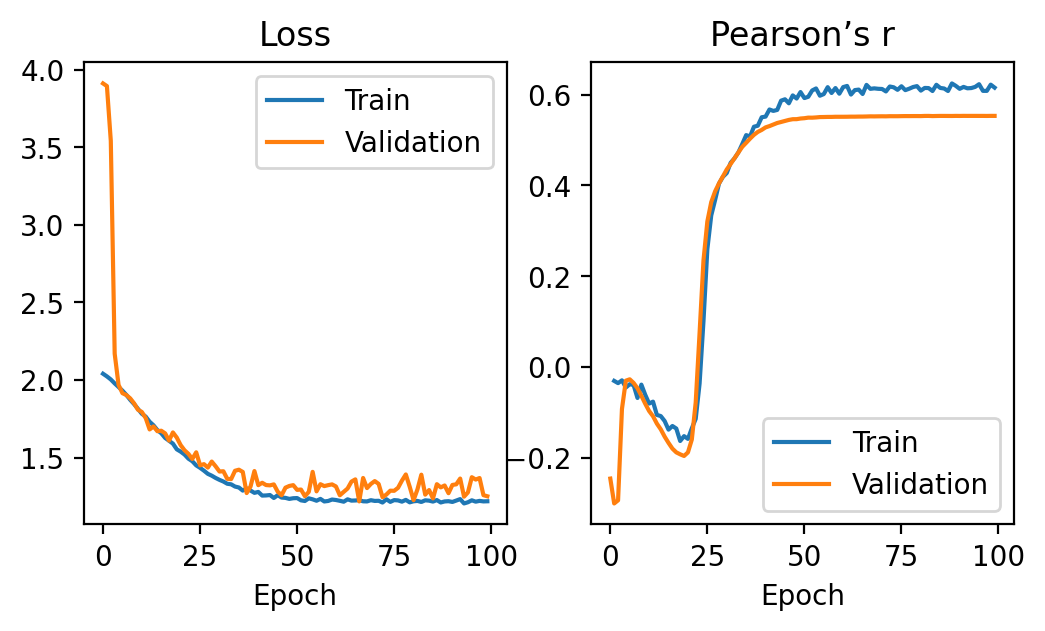

In [34]:
history = state.history

batch_train_loss, batch_train_pearson = [], []
batch_size = len(history["train_loss"]) // len(history["val_loss"])
epoch = len(history["val_loss"])

for i in range(0, len(history["train_loss"]), batch_size):
  batch_train_loss.append(sum(history["train_loss"][i:i+batch_size]) / batch_size)
  batch_train_pearson.append(sum(history["train_pearson"][i:i+batch_size]) / batch_size)


fig, ax = plt.subplots(figsize=(6, 3), ncols=2, dpi=200)

ax[0].plot([e for e in range(epoch)], batch_train_loss, label="Train")
ax[0].plot([e for e in range(epoch)], history["val_loss"], label="Validation")
ax[0].set_title("Loss")
ax[0].set_xlabel("Epoch")
ax[0].legend()


ax[1].plot([e for e in range(epoch)], batch_train_pearson, label="Train")
ax[1].plot([e for e in range(epoch)], history["val_pearson"], label="Validation")
ax[1].set_title("Pearson’s r")
ax[1].set_xlabel("Epoch")
ax[1].legend()

In [1]:
# epoch 100, batch_per_epoch 20, sample size 10240
# seed = 9527
# torch.manual_seed(seed)
# np.random.seed(seed)
# random.seed(seed)

# trainer, p = create_trainer(model, optimizer, scheduler, criterion, device, model_dir,
#                             use_validation=use_validation, valid_dl=valid_dl)

# # log_dir = model_dir / "logs"

# # tb_logger = TensorboardLogger(log_dir=log_dir)
# # tb_logger.attach_output_handler(
# #         trainer,
# #         event_name=Events.ITERATION_COMPLETED,
# #         tag="training",
# #         output_transform=lambda loss: {"batchloss": loss},
# # )

# state = trainer.run(train_dl, max_epochs=epoch_num)

In [96]:
with open(GOOGLE_DRIVE_PATH + '/legnet_metrics_100_20_512.pkl', 'wb') as f:
    pickle.dump([], f)

torch.save(model.state_dict(), GOOGLE_DRIVE_PATH + '/legnet_100_20_512.pt') # epoch, batch_per_epoch, batch_size

# Simple example


In [ ]:
class Test_model(nn.Module):
    def __init__(self):
        super().__init__()
         # dimension of the each sample is 4 x 150. for simplicity,
         # I use linear layer so input was reshape to 600
        self.linear = nn.Linear(600, 18)
        self.log_soft_max = nn.LogSoftmax(dim=1)

        self.register_buffer('bins', torch.arange(start=0, end=18, step=1, requires_grad=False)) # 18 classes

    def forward(self, input):
        """
        input: (batch_size, channel, segsize)
            turn off single_channel, reverse_channel, multisubstate_channel, then channel == 4
        """
        input = input.view(-1, 600) # reshape the input from 4 x 150 to 600 for linear layer
        output = self.linear(input)
        logprobs = self.log_soft_max(output)

        score = F.softmax(output, dim=1)
        score = (score * self.bins).sum(dim=1) # I have no idea why the output times the weights...???

        return logprobs, score # logprobs for training and score is the y_pred

In [ ]:
test_model = test_model().to(device)
test_model.apply(initialize_weights)

test_model(
  (linear): Linear(in_features=600, out_features=18, bias=True)
  (log_soft_max): LogSoftmax(dim=1)
)

In [ ]:
max_lr = 1e-5
div_factor = 20

In [ ]:
criterion = nn.MSELoss().to(device)
optimizer = get_optimizer(optimizer_name, test_model.parameters(), .01, weight_decay)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=max_lr,
                                                div_factor=div_factor,
                                                steps_per_epoch=batch_per_epoch,
                                                epochs=epoch_num,
                                                pct_start=0.3,
                                                three_phase="store_true"
                                               )

In [ ]:
trainer, p = create_trainer(test_model, optimizer, scheduler, criterion, device, model_dir,
                            use_validation=use_validation, valid_dl=train_dl)

state = trainer.run(train_dl, max_epochs=epoch_num)